In [1]:
# Import the necessary libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
import tensorflow as tf

sns.set(style='white', context='notebook', palette='deep')

In [2]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')
sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

print("Data are Ready!!")

Data are Ready!!


In [3]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")


Training data size is (42000, 785)
Testing data size is (28000, 784)


In [4]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1) 

In [5]:
# Load more data sets, if there is no such data, validation accuracy = 0.9964
# With this batch of data, the validation accuracy can reach 0.9985
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

Y_train1 = y_train1
X_train1 = train1.reshape(-1, 28*28)

11493376/11490434 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


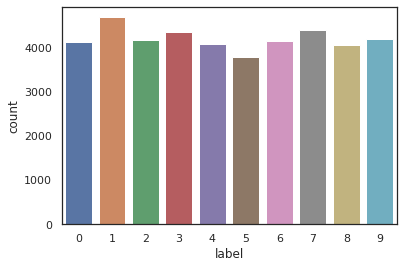

In [6]:
# Print data histogram
sns.countplot(Y_train);

In [7]:
# Normalize data to make CNN faster
X_train = X_train / 255.0
test = test / 255.0

X_train1 = X_train1 / 255.0

In [8]:
# Reshape Picture is 3D array (height = 28px, width = 28px , canal = 1)
X_train = np.concatenate((X_train.values, X_train1))
Y_train = np.concatenate((Y_train, Y_train1))

In [9]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X_train = X_train.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [10]:
# Convert label to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [11]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape


((100800, 28, 28, 1), (11200, 28, 28, 1), (100800, 10), (11200, 10))

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model

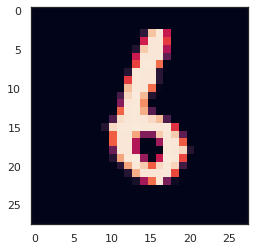

In [12]:
# Draw an example of a data set to see
g = plt.imshow(X_train[189][:,:,0])

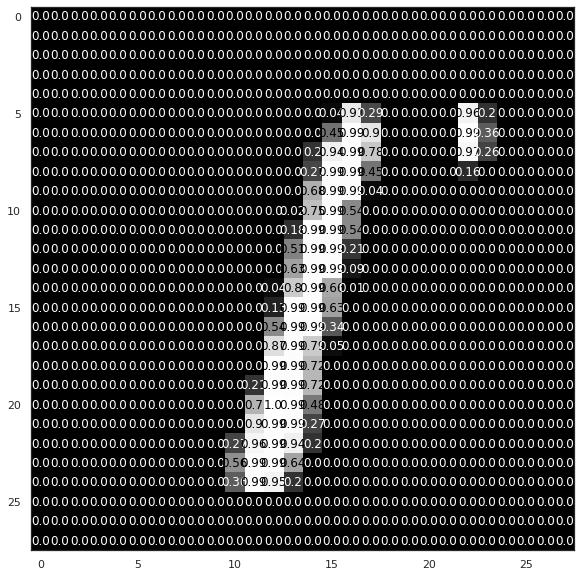

In [13]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input(X_train[27].reshape(28,28), ax)


#Creating CNN model

  [[Conv2D->relu]*2 -> BatchNormalization -> MaxPool2D -> Dropout]*2 -> 
  [Conv2D->relu]*2 -> BatchNormalization -> Dropout -> 
  Flatten -> Dense -> BatchNormalization -> Dropout -> Out

In [14]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))



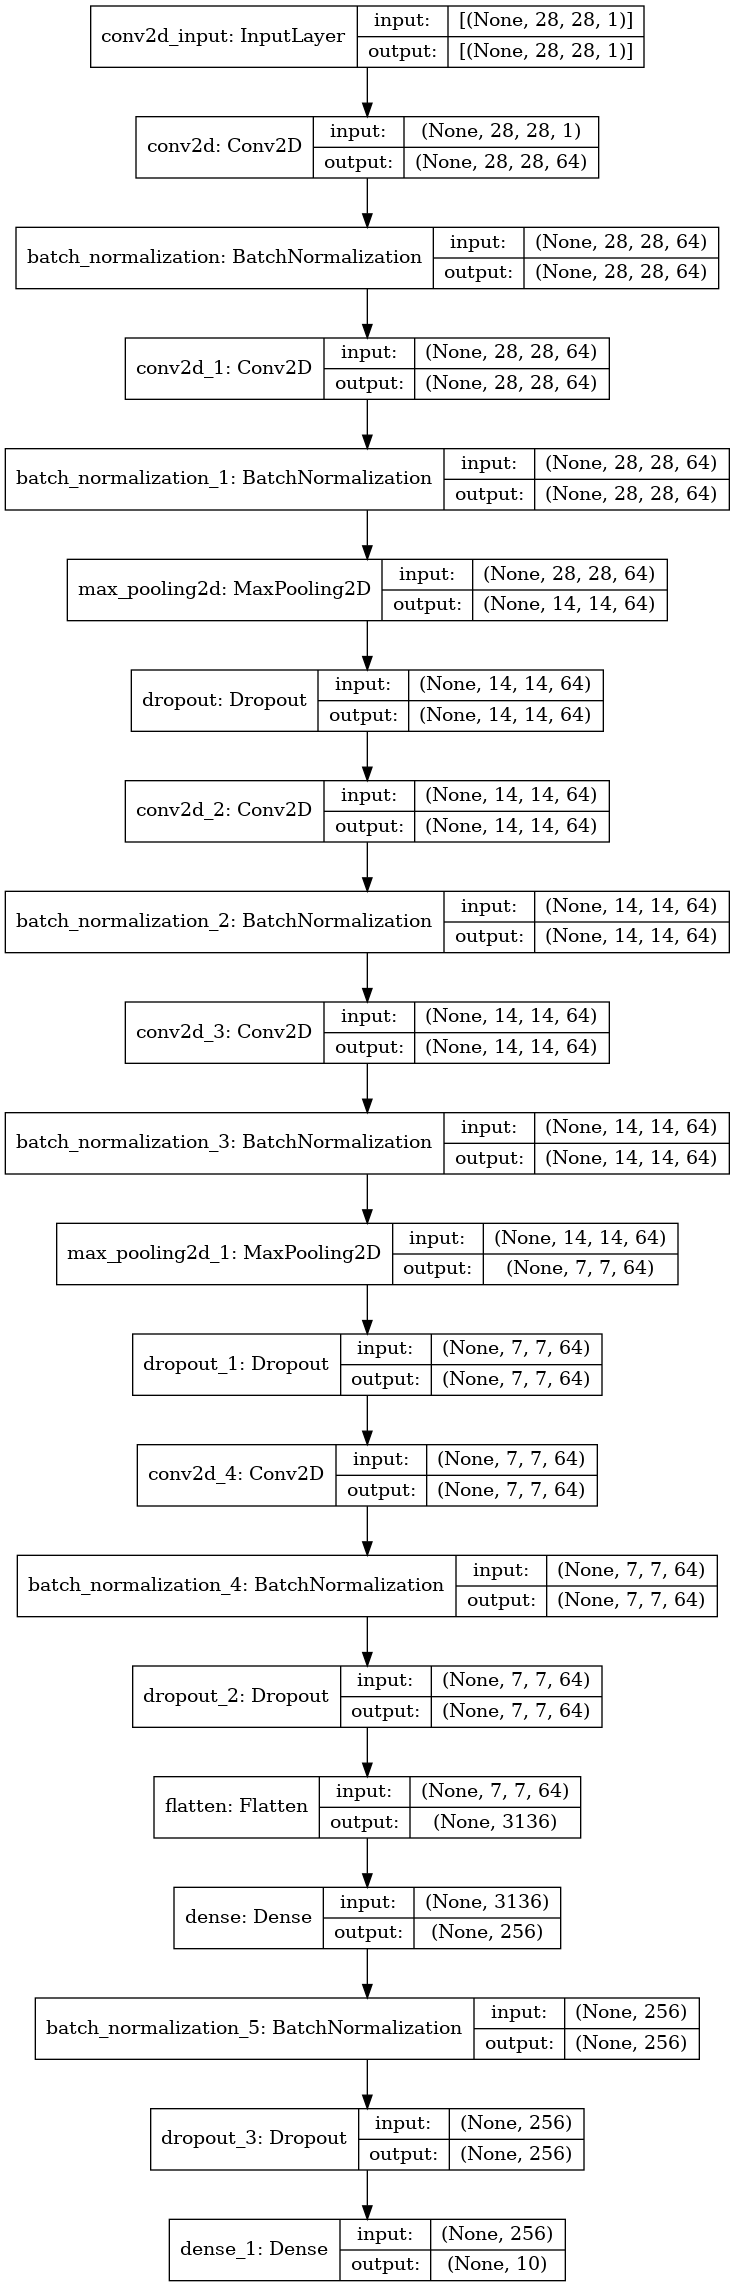

In [15]:
# print out model look
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [16]:
# Define Optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [17]:
# Compile model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [18]:
# Audjusting learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
#Adjusting epochs and batch_size
epochs = 50
batch_size = 128


In [20]:
#Data Augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#datagen.fit(X_train)
train_gen = datagen.flow(X_train,Y_train, batch_size=batch_size)

For the data augmentation, i choosed to :

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
* I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [21]:
#Prediction model
history = model.fit(train_gen,
                              epochs = epochs,validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],
                             validation_steps = X_val.shape[0] // batch_size)

Epoch 1/50
787/787 - 35s - loss: 0.1431 - accuracy: 0.9556 - val_loss: 0.0500 - val_accuracy: 0.9857
Epoch 2/50
787/787 - 27s - loss: 0.0508 - accuracy: 0.9843 - val_loss: 0.0393 - val_accuracy: 0.9887
Epoch 3/50
787/787 - 26s - loss: 0.0384 - accuracy: 0.9883 - val_loss: 0.0306 - val_accuracy: 0.9904
Epoch 4/50
787/787 - 27s - loss: 0.0339 - accuracy: 0.9898 - val_loss: 0.0227 - val_accuracy: 0.9933
Epoch 5/50
787/787 - 26s - loss: 0.0296 - accuracy: 0.9910 - val_loss: 0.0163 - val_accuracy: 0.9943
Epoch 6/50
787/787 - 26s - loss: 0.0262 - accuracy: 0.9920 - val_loss: 0.0215 - val_accuracy: 0.9937
Epoch 7/50
787/787 - 27s - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0150 - val_accuracy: 0.9956
Epoch 8/50
787/787 - 26s - loss: 0.0234 - accuracy: 0.9931 - val_loss: 0.0149 - val_accuracy: 0.9954
Epoch 9/50
787/787 - 27s - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.0125 - val_accuracy: 0.9962
Epoch 10/50
787/787 - 26s - loss: 0.0214 - accuracy: 0.9940 - val_loss: 0.0114 - val_accura

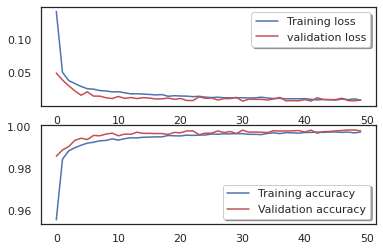

In [22]:
# Draw the loss and accuracy curves of the training set and the validation set.
# Can judge whether it is under-fitting or over-fitting
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


Confusion matrix can be very helpful to see your model drawbacks and behavior.

I plot the confusion matrix of the validation results.

In [23]:
# Draw a confusion matrix that can be used to observe high false positives

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');


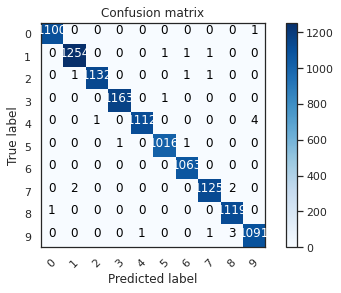

In [24]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [25]:
# Show some wrong results, and the difference between the predicted label and the real labe
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [26]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

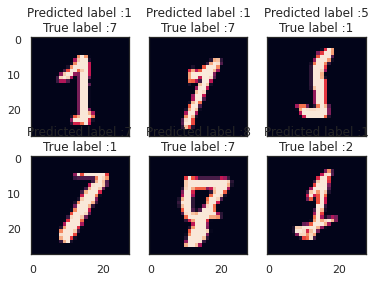

In [27]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [28]:
# Make predictions about test sets
results = model.predict(test)

# Convert one-hot vector to number
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [29]:
# Save the final result in cnn_mnist_submission.csv
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_submission.csv",index=False)

I performed kNN k=1 with Kaggle's 28,000 "test.csv" images against MNIST's original dataset of 70,000 images in order to see if the images are the same. The result verifies that Kaggle's unknown "test.csv" images are entirely contained unaltered within MNIST's original dataset with known labels. Therefore we CANNOT train with MNIST's original data, we must train our models with Kaggle's "train.csv" 42,000 images, data augmentation, and/or non-MNIST image datasets.

In [30]:
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

Y_train1 = y_train1
X_train1 = x_train1.reshape(-1, 28*28)

In [31]:
mnist_image = np.vstack((x_train1,x_test1))
mnist_image = mnist_image.reshape(-1,784)
print(mnist_image.shape)
mnist_label = np.vstack((y_train1.reshape(-1,1),y_test1.reshape(-1,1)))
print(mnist_label.shape)


(70000, 784)
(70000, 1)


In [32]:
train_data = pd.read_csv('../input/digit-recognizer/train.csv')
test_data  = pd.read_csv('../input/digit-recognizer/test.csv')

In [33]:
train_images = train_data.copy()
train_images = train_images.values
X_train = train_images[:,1:]
y_train = train_images[:,0]
X_test = test_data.values

In [34]:
X_train = X_train.reshape(-1,28,28)
y_train = y_train.reshape(-1,1)

print(X_train.shape)
print(y_train.shape)

(42000, 28, 28)
(42000, 1)


In [35]:
predictions = np.zeros((X_train.shape[0]))


In [36]:
x1=0
x2=0
print("Classifying Kaggle's 'test.csv' using KNN where K=1 and MNIST 70k images..")
for i in range(0,28000):
    for j in range(0,70000):
        if np.absolute(X_test[i,:]-mnist_image[j,:]).sum()==0:
            predictions[i]=mnist_label[j]
            if i%1000==0:
                print("  %d images classified perfectly"%(i),end="")
            if j<60000:
                x1+=1
            else:
                x2+=1
            break

if x1+x2==28000:
    print(" 28000 images classified perfectly.")
    print("All 28000 images are contained in MNIST.npz Dataset.")
    print("%d images are in MNIST.npz train and %d images are in MNIST.npz test"%(x1,x2))

Classifying Kaggle's 'test.csv' using KNN where K=1 and MNIST 70k images..
  0 images classified perfectly  1000 images classified perfectly  2000 images classified perfectly  3000 images classified perfectly  4000 images classified perfectly  5000 images classified perfectly  6000 images classified perfectly  7000 images classified perfectly  8000 images classified perfectly  9000 images classified perfectly  10000 images classified perfectly  11000 images classified perfectly  12000 images classified perfectly  13000 images classified perfectly  14000 images classified perfectly  15000 images classified perfectly  16000 images classified perfectly  17000 images classified perfectly  18000 images classified perfectly  19000 images classified perfectly  20000 images classified perfectly  21000 images classified perfectly  22000 images classified perfectly  23000 images classified perfectly  24000 images classified perfectly  25000 images classified perfectly  26000 images classified pe

In [37]:
final_pred = predictions[0:28000]
final_pred.shape

(28000,)

In [38]:
my_submission = pd.DataFrame({'ImageId':np.arange(28000),'Label':final_pred.squeeze().astype(np.int)})


In [39]:
my_submission["ImageId"]=my_submission["ImageId"]+1
my_submission.to_csv('best_submission.csv', index=False)
